In [1]:
from imblearn.combine import SMOTEENN

In [2]:
import pandas as pd
from sklearn.metrics import pairwise_distances

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import numpy as np


2024-10-28 16:08:29.608049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# carregando os datasets
cervejas = pd.read_csv('./datasets/preprocessed/CERVEJAS_processed.csv')
harmonizacoes = pd.read_csv('./datasets/preprocessed/HARMONIZACOES_processed.csv')
ingredientes = pd.read_csv('./datasets/preprocessed/INGREDIENTES_processed.csv')
pratos = pd.read_csv('./datasets/preprocessed/PRATOS_processed.csv')
treino_final = pd.read_csv('./datasets/preprocessed/PRATOxCERVEJA_processed.csv')

In [5]:
# atributos de cerveja
range_atributos_cerveja = ['ibumin', 'ibumax', 'ogmin', 'ogmax', 'fgmin', 'fgmax', 'abvmin', 'abvmax', 'srmmin', 'srmmax']
atributos_cerveja = ['ibu', 'og', 'fg', 'abv', 'srm']

# atributos de sabor dos alimentos
todos_sabores = [col for col in ingredientes.columns if col not in ['ingrediente', 'categoria']]


In [6]:
### DEFININDO VARIAVEIS ###

In [7]:
# Definindo as colunas X e Y
X = treino_final[todos_sabores]  # atributos de sabor dos pratos
Y = treino_final[atributos_cerveja]  # atributos de sabor da cerveja



In [8]:
# Dividindo os dados em conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [9]:
### TREINAMENTO DO MODELO ###

In [10]:
# Construindo a rede neural
modelo_nn = Sequential()
modelo_nn.add(Input(shape=(len(todos_sabores),)))  # Definindo a forma da entrada usando Input
modelo_nn.add(Dense(256, activation='relu'))  # Primeira camada oculta
modelo_nn.add(Dense(128, activation='relu'))  # Segunda camada oculta
modelo_nn.add(Dense(64, activation='relu'))  # Terceira camada oculta
modelo_nn.add(Dense(len(atributos_cerveja), activation='linear'))  # Camada de saída com 5 atributos de cerveja


In [11]:
# Compilando o modelo
modelo_nn.compile(optimizer='adam', loss='mean_squared_error')



In [12]:
# Treinando o modelo
history = modelo_nn.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))



Epoch 1/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0272 - val_loss: 0.0218
Epoch 2/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0216 - val_loss: 0.0212
Epoch 3/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0215 - val_loss: 0.0211
Epoch 4/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 5/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 6/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0210 - val_loss: 0.0208
Epoch 7/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0210 - val_loss: 0.0208
Epoch 8/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0211 - val_loss: 0.0209
Epoch 9/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0210 - val_loss: 0.0208
Epoch 10/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 11/100
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0209 - val_loss: 0.0208
Epoch 12/100
1386/1

In [13]:
# Avaliando o modelo
score = modelo_nn.evaluate(X_test, Y_test, verbose=0)
print(f"Mean Squared Error no conjunto de teste: {score}")


Mean Squared Error no conjunto de teste: 0.02133023738861084


In [14]:
### FUNÇÕES PARA PREVER RECOMENDACOES ###

In [15]:
# função para buscar o estilo de cerveja mais próximo com base nos atributos previstos.
def buscar_estilo_cerveja(predicao_cerveja, cervejas_df, atributos_cerveja):
    # Calculando a distância euclidiana entre a previsão e todos os estilos de cerveja
    distancias = pairwise_distances(cervejas_df[atributos_cerveja], predicao_cerveja.reshape(1, -1))

    # Encontrando o índice da cerveja mais próxima
    indice_mais_proxima = np.argmin(distancias)

    # Retornando o estilo da cerveja mais próxima
    return cervejas_df.iloc[indice_mais_proxima]['estilo']  # Substitua 'estilo' pelo nome da coluna de estilo

In [16]:
# RECOMENDA CERVEJA POR INGREDIENTES

# Função que retorna os atributos de cerveja com base na lista de ingredientes utilizando o modelo treinado
def buscar_ingrediente_nn(ingredientes_lista, modelo, ingredientes_df, todos_sabores):
    ingredientes_selecionados = ingredientes_df[ingredientes_df['ingrediente'].isin(ingredientes_lista)]
    ingredientes_nao_encontrados = set(ingredientes_lista) - set(ingredientes_selecionados['ingrediente'])
    
    if ingredientes_nao_encontrados:
        print(f"Atenção: os seguintes ingredientes não foram encontrados: {ingredientes_nao_encontrados}")
    
    if not ingredientes_selecionados.empty:
        soma_sabores = ingredientes_selecionados[todos_sabores].sum(axis=0).values.reshape(1, -1)
        predicao_cerveja = modelo.predict(soma_sabores)
        return predicao_cerveja[0]
    else:
        return None

# Função que retorna as cervejas que mais combinam com a lista de ingredientes, garantindo 3 estilos diferentes
def recomendar_cerveja_por_ingrediente_nn(ingredientes_lista, modelo, ingredientes_df, todos_sabores, cervejas_df, atributos_cerveja):
    predicao = buscar_ingrediente_nn(ingredientes_lista, modelo, ingredientes_df, todos_sabores)
    
    if predicao is not None:
        # Calculando as distâncias entre a previsão e cada cerveja
        distancias = pairwise_distances(cervejas_df[atributos_cerveja], [predicao])
        cervejas_df['distancia'] = distancias
        
        # Ordenando as cervejas pela distância e garantindo estilos diferentes
        cervejas_unicas = cervejas_df.drop_duplicates(subset=['estilo']).sort_values(by='distancia').head(3)
        
        # Normalizando as distâncias para cálculo de porcentagem de similaridade
        menor_distancia = cervejas_unicas['distancia'].min()
        recomendacoes = []
        for _, row in cervejas_unicas.iterrows():
            # A menor distância (a mais próxima) será 100%, e as demais escaladas proporcionalmente
            # similaridade = 100 * (1 - (row['distancia'] - menor_distancia) / menor_distancia)
            similaridade = 100 - ((row['distancia'] / max(distancias.flatten())) * 100)
            recomendacoes.append((row['estilo'], similaridade))
        
        return recomendacoes
    else:
        return "Não foi possível realizar a previsão com os ingredientes fornecidos."


In [17]:
# RECOMENDA CERVEJA POR PRATO

# Função que retorna os atributos de cerveja com base em um prato utilizando o modelo treinado
def buscar_prato_nn(prato, modelo, pratos_df, todos_sabores):
    # Filtrando os pratos no DataFrame 'pratos' com base nas duas colunas
    pratos_selecionados = pratos_df[
        pratos_df['prato'].isin(prato) | pratos_df['pratos_allrecipes'].isin(prato)
    ]
    
    # Verificando se todos os pratos foram encontrados
    pratos_nao_encontrados = set(prato) - set(pratos_selecionados['prato']).union(set(pratos_selecionados['pratos_allrecipes']))
    if pratos_nao_encontrados:
        print(f"Atenção: os seguintes pratos não foram encontrados: {pratos_nao_encontrados}")

    # Somando os atributos de sabor dos pratos encontrados
    if not pratos_selecionados.empty:
        soma_sabores = pratos_selecionados[todos_sabores].sum(axis=0).values.reshape(1, -1)
        
        # Prevendo os atributos de cerveja usando o modelo neural
        predicao_cerveja = modelo.predict(soma_sabores)
        return predicao_cerveja[0]  # Retorna os 5 atributos de cerveja previstos
    else:
        return None

# Função que retorna as cervejas que mais combinam com o prato, garantindo 3 estilos diferentes
def recomendar_cerveja_por_prato_nn(prato, modelo, pratos_df, todos_sabores, cervejas_df, atributos_cerveja):
    # Prever os atributos de cerveja com base nos pratos
    predicao = buscar_prato_nn(prato, modelo, pratos_df, todos_sabores)
    
    if predicao is not None:
        # Calculando as distâncias entre a previsão e cada cerveja
        distancias = pairwise_distances(cervejas_df[atributos_cerveja], [predicao])
        cervejas_df['distancia'] = distancias
        
        # Ordenando as cervejas pela distância
        cervejas_unicas = cervejas_df.drop_duplicates(subset=['estilo']).sort_values(by='distancia').head(3)
        
        # Normalizando as distâncias para cálculo de porcentagem de similaridade
        menor_distancia = cervejas_unicas['distancia'].min()
        recomendacoes = []
        
        for _, row in cervejas_unicas.iterrows():
            similaridade = 100 - ((row['distancia'] / max(distancias.flatten())) * 100)
            recomendacoes.append((row['estilo'], similaridade))
        
        return recomendacoes
    else:
        return "Não foi possível realizar a previsão com o prato fornecido."



In [18]:
### TESTANDO RECOMENDACAO ###

In [19]:
# Testando recomendação de cerveja com base em um conjunto de INGREDIENTES

ingredientes_input_variados = [
    ['chicken', 'yogurt', 'cheese', 'cream cheese', 'salt', 'corn', 'potato chip', 'rice']
    # ['pepper', 'sugar', 'cheese', 'salt'],
    # ['pepper sauce', 'sugar', 'cheese', 'salt']
    # ['pasta', 'tomato'],
    # ['chicken', 'bread', 'onion', 'sugar'],
    # ['tomato', 'bread', 'garlic'],
    # ['pasta', 'tomato', 'basil', 'cheese'],
    # ['bread', 'meat', 'tomato', 'cheese', 'lettuce','bacon'],
    # ['bread', 'chicken', 'tomato', 'cheese', 'lettuce','bacon'],
    # ['bread', 'hamburger', 'tomato', 'cheese', 'lettuce','bacon'],
    # ['bacon', 'cheese', 'salt']
]

for ingredientes_input in ingredientes_input_variados:
    estilo_recomendado_nn = recomendar_cerveja_por_ingrediente_nn(
        ingredientes_input, modelo_nn, ingredientes, todos_sabores, cervejas, atributos_cerveja
    )
    
    print(f"\nPrevisão para ingredientes {ingredientes_input}:")
    
    if isinstance(estilo_recomendado_nn, list):
        for i, (cerveja, porcentagem) in enumerate(estilo_recomendado_nn, start=1):
            print(f"  {i}. {cerveja} - {porcentagem:.2f}% de combinação")
    else:
        print(estilo_recomendado_nn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

Previsão para ingredientes ['chicken', 'yogurt', 'cheese', 'cream cheese', 'salt', 'corn', 'potato chip', 'rice']:
  1. Belgian Golden Strong Ale - 10.29% de combinação
  2. Specialty IPA - 10.15% de combinação
  3. Belgian Tripel - 10.04% de combinação


In [25]:
# Testando recomendação de cerveja a partir de um PRATO

pratos_input_variados = [['Pepperoni pizza'], ['cheese fondue'], ['Hamburger']]

for prato_input in pratos_input_variados:
    estilo_recomendado_nn = recomendar_cerveja_por_prato_nn(
        prato_input, modelo_nn, pratos, todos_sabores, cervejas, atributos_cerveja
    )
    
    print(f"\nPrevisão para ingredientes {pratos_input_variados}:")
    
    if isinstance(estilo_recomendado_nn, list):
        for i, (cerveja, porcentagem) in enumerate(estilo_recomendado_nn, start=1):
            print(f"  {i}. {cerveja} - {porcentagem:.2f}% de combinação")
    else:
        print(estilo_recomendado_nn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step

Previsão para ingredientes [['Pepperoni pizza'], ['cheese fondue'], ['Hamburger']]:
  1. American IPA - 92.78% de combinação
  2. British Strong Ale - 89.50% de combinação
  3. English IPA - 89.49% de combinação
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Previsão para ingredientes [['Pepperoni pizza'], ['cheese fondue'], ['Hamburger']]:
  1. Baltic Porter - 93.21% de combinação
  2. Dunkles Bock - 91.53% de combinação
  3. Wee Heavy - 85.10% de combinação
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Previsão para ingredientes [['Pepperoni pizza'], ['cheese fondue'], ['Hamburger']]:
  1. Old Ale - 90.46% de combinação
  2. British Strong Ale - 89.45% de combinação
  3. Helles Bock - 87.80% de combinação


In [53]:
# Testando recomendação de cerveja a partir de um PRATO

pratos_input_variados = [['Pepperoni pizza'], ['cheese fondue'], ['Hamburger']]

for prato_input in pratos_input_variados:
    estilo_recomendado_nn = recomendar_cerveja_por_prato_nn(
        prato_input, modelo_nn, pratos, todos_sabores, cervejas, atributos_cerveja
    )
    
    print(f"\nPrevisão para prato {prato_input}:")
    
    if isinstance(estilo_recomendado_nn, list):
        for i, (cerveja, porcentagem) in enumerate(estilo_recomendado_nn, start=1):
            print(f"  {i}. {cerveja} - {porcentagem:.2f}% de combinação")
    else:
        print(estilo_recomendado_nn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Previsão para prato ['Pepperoni pizza']:
  1. American IPA - 92.78% de combinação
  2. British Strong Ale - 89.50% de combinação
  3. English IPA - 89.49% de combinação
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

Previsão para prato ['cheese fondue']:
  1. Baltic Porter - 93.21% de combinação
  2. Dunkles Bock - 91.53% de combinação
  3. Wee Heavy - 85.10% de combinação
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step

Previsão para prato ['Hamburger']:
  1. Old Ale - 90.46% de combinação
  2. British Strong Ale - 89.45% de combinação
  3. Helles Bock - 87.80% de combinação


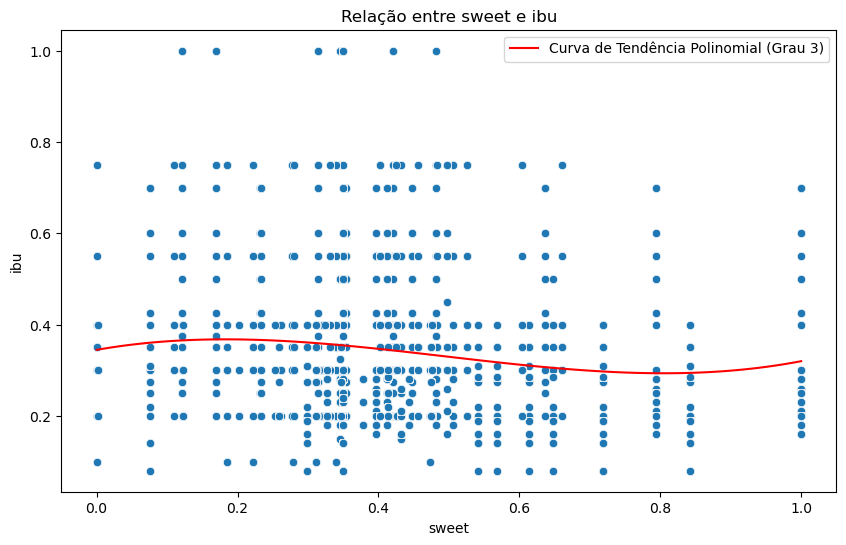

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Exemplo: relação entre um sabor específico e um atributo de cerveja
sabor_especifico = 'sweet'  # Substituir pelo nome real da coluna de sabor
atributo_cerveja = 'ibu'  # Exemplo de atributo de cerveja

plt.figure(figsize=(10, 6))
sns.scatterplot(x=treino_final[sabor_especifico], y=treino_final[atributo_cerveja])

# Adicionando uma curva de regressão polinomial
X_poly = PolynomialFeatures(degree=3).fit_transform(treino_final[[sabor_especifico]])
model = LinearRegression().fit(X_poly, treino_final[atributo_cerveja])
x_range = np.linspace(treino_final[sabor_especifico].min(), treino_final[sabor_especifico].max(), 100)
y_pred = model.predict(PolynomialFeatures(degree=3).fit_transform(x_range.reshape(-1, 1)))
plt.plot(x_range, y_pred, color='red', label="Curva de Tendência Polinomial (Grau 3)")
plt.title(f'Relação entre {sabor_especifico} e {atributo_cerveja}')
plt.xlabel(sabor_especifico)
plt.ylabel(atributo_cerveja)
plt.legend()
plt.show()


In [32]:
sabores_pratos = ['sour', 'bitter', 'sweet', 'fruity', 'grassy','roast', 'caramel', 'fermented','powdery','dry']

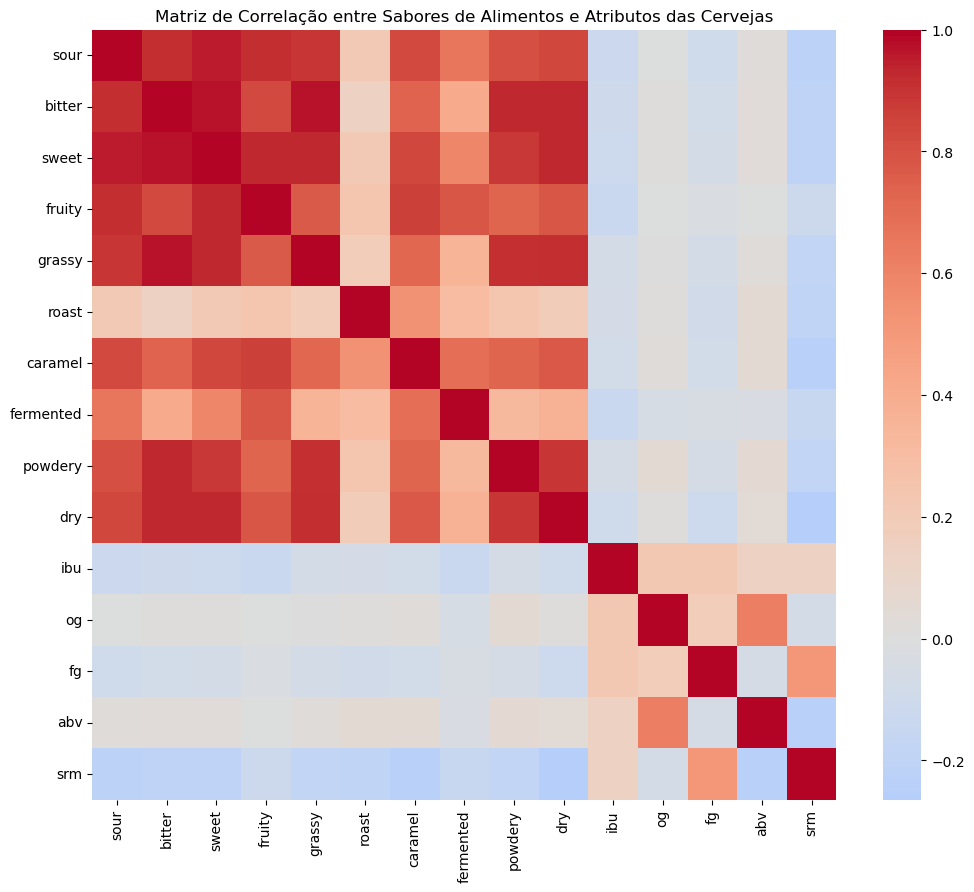

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculando a matriz de correlação
correlacoes = treino_final[sabores_pratos + atributos_cerveja].corr()

# Plotando a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlacoes, annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de Correlação entre Sabores de Alimentos e Atributos das Cervejas")
plt.show()


In [39]:
# Para calcular a correlação de Pearson (padrão)
#correlacao_pearson = df.corr()
correlacao_pearson = treino_final[sabores_pratos + atributos_cerveja].corr()


# Para calcular a correlação de Spearman
correlacao_spearman = treino_final[sabores_pratos + atributos_cerveja].corr(method='spearman')

# Para calcular a correlação de Kendall
correlacao_kendall = treino_final[sabores_pratos + atributos_cerveja].corr(method='kendall')

# Exibindo a matriz de correlação de Pearson, por exemplo
print(correlacao_pearson)
print(correlacao_spearman)
print(correlacao_kendall)



               sour    bitter     sweet    fruity    grassy     roast  \
sour       1.000000  0.914010  0.959594  0.915033  0.895115  0.211960   
bitter     0.914010  1.000000  0.966047  0.828949  0.969272  0.145775   
sweet      0.959594  0.966047  1.000000  0.928325  0.931929  0.211908   
fruity     0.915033  0.828949  0.928325  1.000000  0.767402  0.239783   
grassy     0.895115  0.969272  0.931929  0.767402  1.000000  0.182409   
roast      0.211960  0.145775  0.211908  0.239783  0.182409  1.000000   
caramel    0.828521  0.737851  0.840313  0.861747  0.720240  0.538155   
fermented  0.661473  0.407825  0.585867  0.784981  0.353465  0.306969   
powdery    0.804934  0.928426  0.881779  0.727244  0.907925  0.242255   
dry        0.840973  0.935769  0.934296  0.785234  0.917630  0.194942   
ibu       -0.125077 -0.106114 -0.115065 -0.131000 -0.071124 -0.062747   
og        -0.001260  0.008697  0.016531 -0.001326  0.005441  0.010400   
fg        -0.093036 -0.086216 -0.073700 -0.025302 -